# Best-Practice für Bildklassifikator-Training

In diesem Notebook behandeln wir die grundlegenden Schritte zum Training eines Bauteilklassifikators. Hierbei verwenden wir ein bereits vortrainiertes Modell. D.h. das ML-Modell wird nur noch für unsere Bauteile spezifiert. Die zur Verfügung stehenden Modelle sind alle auf dem imagenet Datensatz (https://www.image-net.org) vortrainiert worden. Dieser Benchmark umfasst 1000 verschiedene Objekte, von Tieren, über Gegenständen bishin zu Personen und Landschaften. Modelle die mit diesem Datensatz trainiert wurden, weisen daher eine hohe Generalisierbarkeit auf, welche wir uns hier zu Nutze machen. Ein weiterer Vorteil ist die verkürzte Trainingsdauer, sowie geringere Trainingsdatenmenge.

## Schritt 1 - Abhängigkeiten und Vorbereitung

In [1]:
#GPU Untrstützung und Abhängigkeiten
import tensorflow as tf
print(tf.__version__ )
tf.config.experimental.list_logical_devices('GPU')


import tensorflow as tf
from tensorflow.keras.layers import Input
import tensorflow.keras.applications as tf_app
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from core import class_prep as pcm
import random
import os
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from AugmentStudyFunc import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

2.6.0


2022-11-17 11:33:30.495198: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Importing /Users/patru/Documents/Forschung/Fbk/KI_in_NFZ/BestPracticeCollection/ki_in_nfz_bestpractices/core/class_prep.py
2.6.0


### Festlegung der Modellarchitekturen
Zunächst legen wir eine Auswahl von Modellarchitekturen fest, welche den aktuellen Stand der Technik wiederspiegeln. Anschließend wählen wir eine Architektur hierfür aus. Genauere Informationen zu den Modellen findet man auf https://www.tensorflow.org/api_docs/python/tf/keras/applications. Wichtig ist hierbei die Festlegung der Auflösung für das Modell. Die meisten Modelle sind für eine Auflösung von 224 x 224 ausgelegt.

In [2]:
mkeys = ['resnet50v2', 'resnet101v2', 'resnet152v2', 'vgg16', 'vgg19', 
        'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb4', 
        'densenet169', 'densenet201', 'inception_v3', 'xception', 'inception_resnet_v2', 'NASNet']

mvalues=[
    tf_app.resnet_v2.ResNet50V2,    tf_app.resnet_v2.ResNet101V2,    tf_app.resnet_v2.ResNet152V2,
    tf_app.vgg16.VGG16,tf_app.vgg19.VGG19,
    tf_app.efficientnet.EfficientNetB0,    tf_app.efficientnet.EfficientNetB1,
    tf_app.efficientnet.EfficientNetB2,    tf_app.efficientnet.EfficientNetB4,
    tf_app.densenet.DenseNet169,    tf_app.densenet.DenseNet201,
    tf_app.inception_v3.InceptionV3,
    tf_app.xception.Xception,
    tf_app.inception_resnet_v2.InceptionResNetV2,
    tf_app.nasnet.NASNetLarge
]
modelArcs = dict(zip(mkeys, mvalues))

input_shape=(224,224)

Danach bauen wir uns eine Hilfsfunktion zur Auswahl und Initialisierung eines Modells

In [3]:
def selectModel(modelName):
    return modelArcs[modelName](weights="imagenet", include_top=False,
        input_tensor=Input(shape=(input_shape[0],input_shape[1], 3)))
model_widget = interactive(selectModel, modelName=mkeys)
display(model_widget)

interactive(children=(Dropdown(description='modelName', options=('resnet50v2', 'resnet101v2', 'resnet152v2', '…

Die untere Zelle muss bei Wechseln des Modells erneut ausgeführt werden.

In [4]:
selectedModel=model_widget.result
model_Name=selectedModel.name
print('Selected Model:',model_Name)

Selected Model: efficientnetb1


## Schritt 2 - Festlegung der der Dateipfade und Modellparameter
In diesem Beispiel haben wir die Funktionalität für das Laden der Daten im Modul "core.classprep" ausgelagert. Die Klasse "core.classprepfileNameHandler" zeigt einige beispielhafte Implementierungen für Parser basierend auf einer CSV Datei. Wir gehen im folgenden davon aus, dass eine csv datei exisitert in der mindestens eine Spalte mit "labeln", also Klassenbezeichnungen und Dateipfaden zu den Bildern vorliegt. Häufig werden die Dateipfade relativ zur CSV Datei angegeben, daher ist auch der Einstiegspunkt für die Dateien mit "dataFilesPrefix" zu setzen.

In [5]:
## Pfad zur CSV in der die Infos zu den Labeln und Dateipfade der Bilder stehen.
datasetCSV='./sample_data/data_sample.csv'

## Nun überprüfen wir noch, ob wir auch darauf zugreifen können.
if not os.path.exists(datasetCSV):
    print('Data CSV File not found:',datasetCSV)
dataFilesPrefix='./'
if not os.path.exists(dataFilesPrefix):
    print('Data CSV File not found:',dataFilesPrefix)

## Zum Schluss legen wir noch den Pfad fest, in der das trainierte Modell abgelegt werden soll
pathToTrained='./trainedModels/bp_exps'
## Wir können natürlich auch erstmal nur die Modelle trainieren und später speichern. In dem Fall auf False setzen.
#- zum sparen von Speicherplatz werden auch immer nur das erste Modell einer Versuchsreihe gespeichert.
saveFirstModel=True

## Festlegung in welcher Spalte die Label zu finden sind.
labelCol='category_2'
    

Als nächstes sind die Modell spezifischen Paramter dran. Um "zufällige" Ergebnisse auszuschließen sollten immer mindestens fün "ran_states" am Ende ausgeführt worden sein.

In [6]:
# - Liste von random states für den train/validation split. Wertebereich von 0 bis 99
ran_states=[42,32,18,84,2]

# - Wieviele Bilder auf einmal verarbeitet werden sollen. 
# Diese sollte immer kleiner sein als die Bilder die pro Klasse zur Verfügung stehen
batches=[32]

# stream data - wenn der RAM nicht ausreichen sollte.
streamData=False

# Anzahl der Trainingsepochen
numEpochs=10

# Festlegung des zu verwendeten Optimierers.
#optis=[Adam,SGD,RMSprop]
optis=[SGD,Adam,RMSprop]

# Festlegung der Lernrate. Achtung diese korreliert direkt mit der batch Größe
#lrates=[1e-1,1e-2,5e-3]
lrates=[1e-2]

# In unserem Fall gibt es noch weitere Attribute im CSV File, welche hier wahlweise an oder abgewählt werden.
trainSets=[['without_shaders'],['shaders_without_bg']]

## Geben wir dem Modellversuchh einen sprechenden Namen
appName='best_practice_exp'

Sind alle Modellparametervariationen ausgewählt, können wir die Hyperparamterstude zusammenbauen. In unserem Beispiel ist dies nur eine Variation.

In [7]:
studyArgList=prepareHyperStudy(ran_states,optis,batches,lrates,trainSets,augMentationSets=None)
print('Hyperstudy length:',len(studyArgList))
studyArgPD=pd.DataFrame(studyArgList,columns=['trainset','ran_state','optimizer','batch_size','learning_rate','testSplit'])
display(studyArgPD)

Hyperstudy length: 30


,trainset,ran_state,optimizer,batch_size,learning_rate,testSplit
0,[without_shaders],42,<class 'keras.optimizer_v2.gradient_descent.SGD'>,32,0.01,0.2
1,[without_shaders],42,<class 'keras.optimizer_v2.adam.Adam'>,32,0.01,0.2
2,[without_shaders],42,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,32,0.01,0.2
3,[without_shaders],32,<class 'keras.optimizer_v2.gradient_descent.SGD'>,32,0.01,0.2
4,[without_shaders],32,<class 'keras.optimizer_v2.adam.Adam'>,32,0.01,0.2
5,[without_shaders],32,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,32,0.01,0.2
6,[without_shaders],18,<class 'keras.optimizer_v2.gradient_descent.SGD'>,32,0.01,0.2
7,[without_shaders],18,<class 'keras.optimizer_v2.adam.Adam'>,32,0.01,0.2
8,[without_shaders],18,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,32,0.01,0.2
9,[without_shaders],84,<class 'keras.optimizer_v2.gradient_descent.SGD'>,32,0.01,0.2


### Auswahl des Parametersatzes für das aktuelle Training und prüfen ob wir die Daten nochmal laden müssen

In [10]:
def selcect_study(param_set):
    return param_set
param_widget = interactive(selcect_study,param_set=studyArgList)
display(param_widget)

interactive(children=(Dropdown(description='param_set', options=((['without_shaders'], 42, <class 'keras.optim…

In [11]:
setting=param_widget.result

## Schritt 3 - Laden der Trainingsdaten und ggf. Testdaten in der für das Modell passenden Form
Zunächst laden wir die CSV Datei ein, welche uns alle notwendigen Informationen liefert. Danach folgt ein optionales Filtern. Je nach Problemstellung, lässt sich hier der Datensatz für das Training noch in alle Richtungen einschränken. In unserem Fall, wollen wir mit den "einfachen"(without_shaders) Bilddaten trainieren und mit den "komplexen" (shaders_with_bg) testen.

Das Ergebnis von -Schritt 2- lässt sich auch super abspeichern, sodass nun Schritt 3 und 4 auf einem leistungsfähigen Rechner ausgeführt werden können.

In [12]:
## CSV einladen und filtern
df_in=pd.read_csv(datasetCSV,sep=';') 
df_train=df_in[df_in['attributes'].isin(setting[0])]
df_test=df_in[df_in['attributes'].isin(['shaders_with_bg'])]

dataTrain,labels,lb,df_train=pcm.loadTrainData('',dataFilesPrefix,input_shape,labelColumnName=labelCol,
                                   trainAtt='',modelName=model_Name,
                                   fileHandlerMode='dmu-exp',df_filtered=df_train)
dataTest,labelsTest,df_test,lbT=pcm.loadTestData('',dataFilesPrefix,input_shape,labelColumnName=labelCol,
                                     modelName=model_Name,
                                     fileHandlerMode='dmu-exp',df_filtered=df_test)




[INFO] loading Training images...
[INFO] use prefiltered DF... 133


100%|██████████| 133/133 [00:00<00:00, 346.89it/s]


NO PREPROCESSING NEEDED - return initial values
[INFO] loading Test images...


100%|██████████| 133/133 [00:00<00:00, 289.64it/s]

NO PREPROCESSING NEEDED - return initial values


## Schritt 4 - Trainieren des Modells mit den gewählten Auswahl an Parametern
Nun können wir das Modell bereits trainieren.

In [13]:
trainX,trainY,valX,valY= pcm.split_data(dataTrain,labels,tt_split=0.2,ran_state=42) 
model = trainExpSetting(selectedModel,input_shape,numEpochs,trainX,trainY,valX,valY,lb,pathToTrained,False,
*setting,appName=appName)

(106, 224, 224, 3) (106, 7)
[Info] Training Model with ranState 42 and Model efficientnetb1
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 448)               28099008  
_________________________________________________________________
dropout (Dropout)            (None, 448)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3143      
Total params: 34,677,390
Trainable 

2022-11-17 11:34:08.165202: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


3/3 [==============================] - 13s 2s/step - loss: 4.8145 - accuracy: 0.4271
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 8.9378 - accuracy: 0.5270
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.5995 - accuracy: 0.8919
Epoch 4/10
3/3 [==============================] - 5s 1s/step - loss: 0.0054 - accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 0.0189 - accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 4s 2s/step - loss: 8.2464e-04 - accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 4s 1s/step - loss: 0.0289 - accuracy: 0.9865
Epoch 8/10
3/3 [==============================] - 4s 1s/step - loss: 0.0206 - accuracy: 0.9865
Epoch 9/10
3/3 [==============================] - 5s 2s/step - loss: 0.0307 - accuracy: 0.9896
Epoch 10/10
3/3 [==============================] - 4s 2s/step - loss: 2.1449e-04 - accuracy: 1.0000
[Info] -- Finished -- Training Model with ranState 

Schauen wir uns zunächst kurz den Verlauf nochmal an

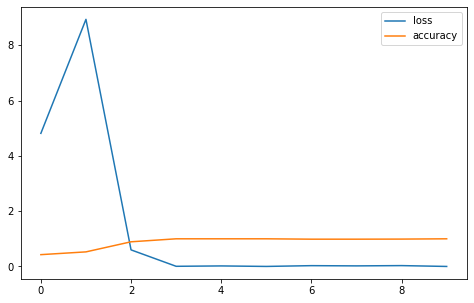

In [14]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Speichern des Modells - Dies kann etwas dauern!
model.save(pathToTrained+'/test_Model')

2022-11-17 11:25:02.998688: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./trainedModels/bp_exps/test_Model/assets


/Users/patru/anaconda3/envs/tf_minimal/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Schritt 5 - Testen des Modells
Wenn wir schon vorher Testdaten bestimmt haben, können wir nun unser Modell dagegen testen. In der zugehörigen Funktion werden die Standard Metriken: Precision, Recall und F1-score ausgegeben.

In [15]:
preds_df=testExpSetting(model,dataTest,labelsTest,lb,pathToTrained,*setting
    ,appName=appName) 

[Info] Test Model with ranState 42 and Model efficientnetb1best_practice_exp
[INFO] evaluating network...
[Info]  -- Finished -- Test Model with ranState 42 and Model efficientnetb1best_practice_exp


Schauen wir uns zunächst die Ergebnisse in einer Tabelle an und gruppieren sie anschließend nach Klasse.

In [16]:
display(preds_df.describe())
display(preds_df.groupby('label').describe())

,precision,recall,f1-score,support,accuracy,ran_state,batch_size,learning_rate,test_split
count,7.000000,7.000000,7.000000,7.0,7.000000e+00,7.0,7.0,7.00,7.000000e+00
mean,0.980519,0.977444,0.977302,19.0,9.774436e-01,42.0,32.0,0.01,2.000000e-01
std,0.051541,0.059679,0.038933,0.0,1.199178e-16,0.0,0.0,0.00,2.997945e-17
min,0.863636,0.842105,0.914286,19.0,9.774436e-01,42.0,32.0,0.01,2.000000e-01
25%,1.000000,1.000000,0.963415,19.0,9.774436e-01,42.0,32.0,0.01,2.000000e-01
50%,1.000000,1.000000,1.000000,19.0,9.774436e-01,42.0,32.0,0.01,2.000000e-01
75%,1.000000,1.000000,1.000000,19.0,9.774436e-01,42.0,32.0,0.01,2.000000e-01
max,1.000000,1.000000,1.000000,19.0,9.774436e-01,42.0,32.0,0.01,2.000000e-01


precision                                                        \
               count      mean std       min       25%       50%       75%   
label                                                                        
Airfilter        1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
Bearing          1.0  0.863636 NaN  0.863636  0.863636  0.863636  0.863636   
Brake            1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
Coupling         1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
Gear_Wheel       1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
Piston           1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   
Rod              1.0  1.000000 NaN  1.000000  1.000000  1.000000  1.000000   

                     recall            ... learning_rate       test_split  \
                 max  count      mean  ...           75%   max      count   
label                                  ...                                  
Airfilter   1.000000    1.0  1.000000  ...          0.01  0.01        1.0   
Bearing     0.863636    1.0  1.000000  ...          0.01  0.01        1.0   
Brake       1.000000    1.0  1.000000  ...          0.01  0.01        1.0   
Coupling    1.000000    1.0  1.000000  ...          0.01  0.01        1.0   
Gear_Wheel  1.000000    1.0  1.000000  ...          0.01  0.01        1.0   
Piston      1.000000    1.0  0.842105  ...          0.01  0.01        1.0   
Rod         1.000000    1.0  1.000000  ...          0.01  0.01        1.0   

                                              
           mean std  min  25%  50%  75%  max  
label                                         
Airfilter   0.2 NaN  0.2  0.2  0.2  0.2  0.2  
Bearing     0.2 NaN  0.2  0.2  0.2  0.2  0.2  
Brake       0.2 NaN  0.2  0.2  0.2  0.2  0.2  
Coupling    0.2 NaN  0.2  0.2  0.2  0.2  0.2  
Gear_Wheel  0.2 NaN  0.2  0.2  0.2  0.2  0.2  
Piston      0.2 NaN  0.2  0.2  0.2  0.2  0.2  
Rod         0.2 NaN  0.2  0.2  0.2  0.2  0.2  

[7 rows x 72 columns]

Jetzt können wir das ganze auch noch visualisieren. Was sich besonders gut eignet, wenn wir mehrere Versuche vergleichen wollen

Text(0, 0.5, 'Performance Score')

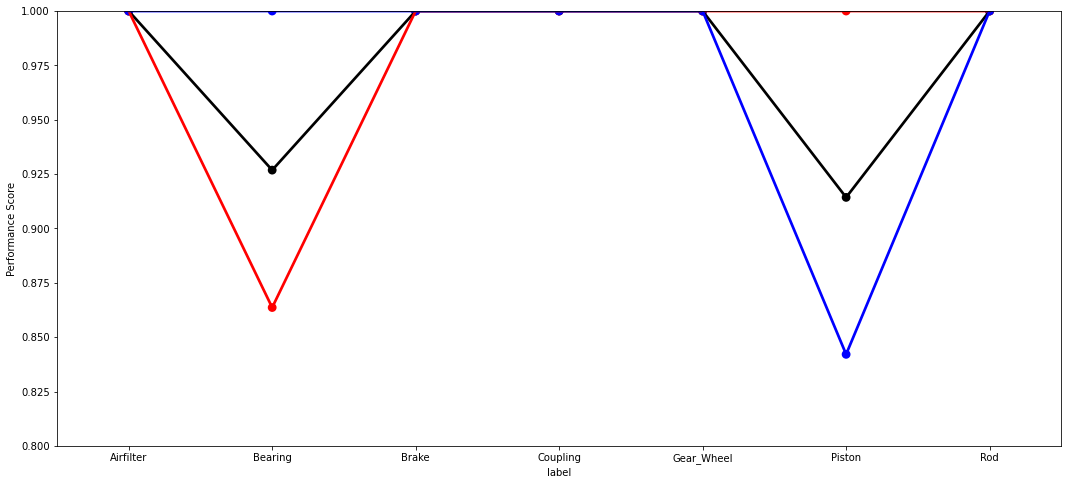

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
# - plot der Metriken, aufgeteilt nach Klassen
fig,axes= plt.subplots(1,1,figsize=(18,8),sharex=True,sharey=True)
sns.pointplot(data=preds_df,x='label',y='f1-score',ax=axes,color='black')
sns.pointplot(data=preds_df,x='label',y='precision',ax=axes,color='red')
sns.pointplot(data=preds_df,x='label',y='recall',ax=axes,color='blue')
axes.set_ylim([0.8,1.0])
axes.set_ylabel('Performance Score')